In [71]:
import os
import glob
import pandas as pd
import lpips
import math
import plotly.express as px
import numpy as np
from natsort import natsorted
import cv2
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import scipy.stats
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import lsqr
from itertools import product
from tqdm import tqdm
import glob
from openpyxl import Workbook
from openpyxl.drawing.image import Image as Image_openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment
from openpyxl.drawing.xdr import XDRPositiveSize2D
from openpyxl.utils.units import pixels_to_EMU, cm_to_EMU
from openpyxl.drawing.spreadsheet_drawing import OneCellAnchor, AnchorMarker
import pickle
import plotly.graph_objects as go
import random
from fractions import Fraction
from scipy.spatial import distance

In [82]:
a = [0, 1, 1, 1, 0, 0, 1]
b = [1, 0, 0, 0, 1, 1, 0]

print(distance.cosine(a, b))

1.0


In [2]:
def shuffle_with_varying_randomness(in_lst, randomness):
    lst = in_lst.copy()
    if not 0 <= randomness <= 1:
        raise ValueError("Randomness must be between 0 and 1")
    
    n = len(lst)
    swaps = int(randomness * n)  # Number of elements to be involved in swaps
    
    for _ in range(swaps):
        i = random.randint(0, n-1)
        j = random.randint(0, n-1)
        lst[i], lst[j] = lst[j], lst[i]

    return lst


In [97]:
def read_csv(path, shuffle_randomness, seed, shuffle):
    csv_df = pd.read_csv(path)
    if shuffle:
        random.seed(seed)
        f_col = list(csv_df.columns)[:1]
        frames = list(csv_df.columns)[1:]
        frames = shuffle_with_varying_randomness(frames, shuffle_randomness)
        updated_col = f_col + frames
        csv_df = csv_df.reindex(columns=updated_col)

    # print([xxc.split('-')[-1].split('_')[-1] for xxc in list(csv_df.columns)][1:])
    init_col = [list(csv_df.columns)[0]]
    csv_df.columns =  init_col + [f'Frame-{xxc}' for xxc in range(len(list(csv_df.columns)[1:]))]
    # print(csv_df.columns)
    return csv_df
    

In [4]:
loss_fn_alex = lpips.LPIPS(net='alex')
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [5]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform_f = transforms.ToTensor()

def normalize_image(in_img):
    pixels = np.asarray(in_img).astype('float32')
    pixels = (pixels - mean) / std
    return pixels

In [6]:
limit_frame_count = -1
ROOT = os.path.abspath(os.path.join(os.curdir, '../'))

In [7]:
images_dir = os.path.join(ROOT, 'Dashboard Data/Images')
data_path = os.path.join(ROOT, 'Dashboard Data')
gt_fol = os.path.join(data_path, "GT_N")
avg_typ = 'micro'

In [8]:
def calculate_model_ap_ar_af1(gt_path, gt_files, pred_path, shuffle_randomness, seed, shuffle, obj_list=None):
    gt_dict = {}
    pred_dict = {}

    for fl in gt_files:
        if fl in ["video-10-segment-1.csv", "video-9-segment-2.csv"]:
            continue
        gt_fl = os.path.join(gt_path, fl)
        pred_fl = os.path.join(pred_path, fl)

        if not os.path.exists(pred_fl):
            continue

        if obj_list:
            gt_data = read_csv(gt_fl, shuffle_randomness=shuffle_randomness, seed=seed, shuffle=shuffle)
            if limit_frame_count > 0:
                if len(list(gt_data.columns)) > limit_frame_count:
                    gt_data = gt_data.iloc[: , :limit_frame_count]

            gt_data = gt_data.transpose()
            gt_data.columns = [x__.lower() for x__ in gt_data.iloc[0]]
            gt_data = gt_data.reindex(columns=obj_list).iloc[1:].transpose().reset_index()

            pred_data = read_csv(pred_fl, shuffle_randomness=shuffle_randomness, seed=seed, shuffle=shuffle)
            if limit_frame_count > 0:
                if len(list(pred_data.columns)) > limit_frame_count:
                    pred_data = pred_data.iloc[: , :limit_frame_count]

            pred_data = pred_data.transpose()
            pred_data.columns = [x__.lower() for x__ in pred_data.iloc[0]]
            pred_data = pred_data.reindex(columns=obj_list).iloc[1:].transpose().reset_index()    
            # print(gt_data)
            # print(pred_data)
        else:
            gt_data = read_csv(gt_fl, shuffle_randomness=shuffle_randomness, seed=seed, shuffle=shuffle)
            if limit_frame_count > 0:
                if len(list(gt_data.columns)) > limit_frame_count:
                    gt_data = gt_data.iloc[: , :limit_frame_count]
            gt_data.replace(-1, 1, inplace=True)
            pred_data = read_csv(pred_fl, shuffle_randomness=shuffle_randomness, seed=seed, shuffle=shuffle)
            if limit_frame_count > 0:
                if len(list(pred_data.columns)) > limit_frame_count:
                    pred_data = pred_data.iloc[: , :limit_frame_count]
            pred_data.replace(-1, 1, inplace=True)
        
        x = []
        for index, row in gt_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in gt_dict.keys():
                gt_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                gt_dict[list(row)[0].strip().lower()] = list(row)[1:]

            x.append(len(list(row)[1:]))

        y = []
        for index, row in pred_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in pred_dict.keys():
                pred_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                pred_dict[list(row)[0].strip().lower()] = list(row)[1:]
            y.append(len(list(row)[1:]))

        if x != y:
            print(len(x), len(y), fl)

    target_array = []
    pred_array = []

    label_names = []

    for key in gt_dict.keys():
        if key in pred_dict.keys():
            if obj_list:
                if key not in obj_list:
                    continue
            if len(gt_dict[key]) == len(pred_dict[key]):
                target_array.append(gt_dict[key])
                pred_array.append(pred_dict[key])
                label_names.append(key)
            else:
                print(len(gt_dict[key]), len(pred_dict[key]), key)
    
    target_array = np.array(target_array).T
    pred_array = np.array(pred_array).T

    # print(target_array.shape)

    # try:
    if pred_path.endswith('GT_N'):
        precs = precision_score(target_array, pred_array, average=avg_typ)
        recs = recall_score(target_array, pred_array, average=avg_typ)
        f1ss = f1_score(target_array, pred_array, average=avg_typ)
    else:
        precs = precision_score(target_array, pred_array, average=avg_typ)
        recs = recall_score(target_array, pred_array, average=avg_typ)
        f1ss = f1_score(target_array, pred_array, average=avg_typ)
    # except Exception as e:
    #     # ap = 0
    #     print(e)
    #     precs = 0.0
    #     recs = 0.0
    #     f1ss = 0.0

    frm_wise_pn_s = (2*target_array) - pred_array

    return precs, recs, f1ss, frm_wise_pn_s

In [9]:
def get_sim_score(img_dir, vid_n, seg_n):
    images = natsorted(glob.glob(
        os.path.join(
            images_dir,
            f'video-{vid_n}-segment-{seg_n}-frame*'
        )
    ))

    d_s = {}
    
    for f in range(1, len(images)):
        f_now_pth = images[f]
        f_prev_pth = images[f-1]

        frm0, frm1 = (os.path.basename(f_prev_pth).split('-')[-1].split('.')[0], 
                      os.path.basename(f_now_pth).split('-')[-1].split('.')[0])

        image_now = cv2.resize(normalize_image(np.array(Image.open(
            f_now_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)
        image_prev = cv2.resize(normalize_image(np.array(Image.open(
            f_prev_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)

        img0 = transform_f(image_now).unsqueeze(0)
        img1 = transform_f(image_prev).unsqueeze(0)

        d = loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]

        d_s[f'{frm0}-{frm1}'] = d
    return d_s

In [34]:
coco_common_obj = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'traffic signals', 'fire hydrant', 'stop sign',
                   'bench', 'dog', 'chair', 'vegetation']

pfb_common_obj = ['road', 'sidewalk', 'tree', 'vegetation', 'building', 'fence', 'traffic signals',
                  'fire hydrant', 'chair', 'trash on roads', 'trash bins', 'person', 'car', 'motorcycle',
                  'bus']

ram_obj_map = {                   
    'chair': 'chair',
    'pillar': 'pillar',
    'table': 'table',
    'person': 'person',
    'man': 'person',
    'building': 'building',
    'city street': 'road',
    'curb': 'curb',
    'pavement': 'sidewalk',
    'road': 'road',
    'car': 'car',
    'snow': 'snow',
    'doorway': 'sloped driveway',
    'elevator': 'elevator',
    'rail': 'train tracks',
    'stair': 'stairs',
    'cane': 'white cane',
    'door': 'flush door',
    'fence': 'fence',
    'barrier': 'barrier post',
    'bench': 'bench',
    'sign': 'sign',
    'bin': 'trash bins',
    'pole': 'pole',
    'street vendor': 'street vendor',
    'blind': 'person with a disability',
    'dog': 'dog',
    'escalator': 'escalator',
    'street sign': 'sign post',
    'bus stop': 'bus stop',
    'railway station': 'train platform',
    'tree': 'tree',
    'traffic light': 'traffic signals',
    'tree trunk': 'tree',
    'recycling bin': 'trash bins',
    'train track': 'train tracks',
    'pedestrian': 'person',
    'bus': 'bus',
    'city bus': 'bus',
    'tour bus': 'bus',
    'wall': 'wall',
    'elevator door': 'elevator',
    'bicycle': 'bicycle',
    'crosswalk': 'crosswalk',
    'decker bus': 'bus',
    'motorcycle': 'motorcycle',
    'motorcyclist': 'person',
    'biker': 'person',
    'motorbike': 'motorcycle',
    'warning sign': 'sign',
    'hydrant': 'fire hydrant',
    'school bus': 'bus',
    'vegetation': 'vegetation',
    'fountain': 'fountain'
}

ram_com_obj = list(set(list(ram_obj_map.values())))
all_com = natsorted(list(set(ram_com_obj) & set(coco_common_obj) & set(pfb_common_obj)))
print(len(all_com))

8


In [35]:
# 2**12

In [36]:
# all_com = list(set(coco_common_obj + pfb_common_obj))[-12:]
# print(len(all_com))

In [37]:
# all_com[-12:]

In [38]:
gt_dir = gt_fol # "/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/GT_N"

gts = natsorted(os.listdir(gt_dir))

skip_list = [
    "video-10-segment-1.csv", "video-9-segment-2.csv"
]

gts = [x.split('.')[0] for x in gts if x.endswith('.csv') and int(x.split('-')[1])<=16 and x not in skip_list]#[:1]

# gts = ['video-1-segment-4']

len(gts)

19

In [39]:
def laplace_smoothing(mat, alpha):
    N_t_s = mat.sum(axis=1)
    d_ps = N_t_s.shape[0]
    
    for ind, row in enumerate(mat):
        # new_row = (row + alpha) * (N_t_s[ind] / (N_t_s[ind] + (alpha * d_ps)))
        # new_row = new_row / (np.sum(new_row) + 1e-20)
        new_row = (row + alpha) / (N_t_s[ind] + (alpha * d_ps))
        mat[ind] = new_row

    return mat

In [221]:
def get_transition_matrix(pred_file, objs, shuffle_randomness, seed, shuffle):
    pred_df = read_csv(pred_file, shuffle_randomness=shuffle_randomness, seed=seed, shuffle=shuffle)
    if limit_frame_count > 0:
        if len(list(pred_df.columns)) > limit_frame_count:
            pred_df = pred_df.iloc[: , :limit_frame_count]
    pred_df = pred_df.transpose()
    pred_df.columns = pred_df.iloc[0]
    pred_df = pred_df.iloc[1:]
    pred_df.columns = map(str.lower, pred_df.columns)
    if objs is not None:
        pred_df = pred_df.reindex(columns=objs)

    pred_df = pred_df.fillna('0').transpose()
    
    pred = np.array(pred_df).T
            
    unq_st_str = []
    n_o_f = 2**(len(objs))
    
    for x in range(n_o_f):
        str_bit = str(bin(x)).replace('0b', '').zfill(len(objs))
        unq_st_str.append(str_bit)

    transition_matrix_dict = {
        'st': [x for x in unq_st_str]
    }
    for u_s_s in unq_st_str:
        transition_matrix_dict[u_s_s] = [0.0 for _ in unq_st_str]

    transition_matrix = pd.DataFrame(transition_matrix_dict)
    transition_matrix = transition_matrix.set_index('st')

    act_st = []

    for f in range(1, pred.shape[0]):
        s_prev = ''.join([str(ch) for ch in pred[f-1]])
        s_now = ''.join([str(ch) for ch in pred[f]])
        transition_matrix[s_now][s_prev] += 1.0
        if f == 1:
            act_st.append(int(s_prev, 2))
            act_st.append(int(s_now, 2))
        else:
            act_st.append(int(s_now, 2))

    transition_matrix = np.array(transition_matrix)

    transition_matrix = laplace_smoothing(transition_matrix, alpha=0.0)  # max([np.max(transition_matrix)/5]) 1e-2

    for tr_ind, tm_row in enumerate(transition_matrix):
        if tm_row.sum() == 0.0:
            transition_matrix[tr_ind] = tm_row + 1/tm_row.shape[0]
            
    return transition_matrix, act_st


def get_transition_matrix_from_arr(pred, alpha=0):
    unq_st_str = []
    n_o_f = 2**(pred.shape[1])
    
    for x in range(n_o_f):
        str_bit = str(bin(x)).replace('0b', '').zfill(pred.shape[1])
        unq_st_str.append(str_bit)

    transition_matrix_dict = {
        'st': [x for x in unq_st_str]
    }
    for u_s_s in unq_st_str:
        transition_matrix_dict[u_s_s] = [0.0 for _ in unq_st_str]

    transition_matrix = pd.DataFrame(transition_matrix_dict)
    transition_matrix = transition_matrix.set_index('st')

    for f in range(1, pred.shape[0]):
        s_prev = ''.join([str(ch) for ch in pred[f-1]])
        s_now = ''.join([str(ch) for ch in pred[f]])
        transition_matrix[s_now][s_prev] += 1.0

    transition_matrix = np.array(transition_matrix)

    transition_matrix = laplace_smoothing(transition_matrix, alpha=alpha)  # max([np.max(transition_matrix)/5])

    for tr_ind, tm_row in enumerate(transition_matrix):
        if tm_row.sum() == 0.0:
            transition_matrix[tr_ind] = tm_row + 1/tm_row.shape[0]
            
    return transition_matrix

In [222]:
def get_st_p_from_t_mat(transition_matrix):
    I = np.identity(transition_matrix.shape[0])
    P_I = transition_matrix - I
    co_eff = P_I.T

    const = np.array([0.0 for _ in range(co_eff.shape[0])])
    co_eff =  np.append(np.ones((1, co_eff.shape[1])), co_eff, axis=0)
    const = np.append(np.array([1]), const)
    

    try:
        p_s_ifs = lsqr(co_eff, const)[0] # np.linalg.solve(co_eff, const)
    except:
        print(det(co_eff), vid_n, seg_n)
        p_s_ifs = lsqr(co_eff, const)[0] # np.linalg.solve(co_eff, const)

    p_s_ifs = list(p_s_ifs)
    # print(p_s_ifs)
    # for s_ind in range((2**(unq_st[0].shape[0]))-len(p_s_ifs)):
    #     p_s_ifs.append(0.0)

    # p_s_ifs = np.array(p_s_ifs)

    return p_s_ifs

In [223]:
def get_entropy(ss_probs):
    if len(ss_probs) <= 1:
        return 0.0

    tot_ss_ent = 0

    for prb in ss_probs:
        if prb == 0:
            log_p_ss = 0
        else:
            try:
                log_p_ss = math.log2(prb)
            except:
                log_p_ss = 0.0 # math.log2(prb+1e-15)

        t_ent = - prb * log_p_ss

        tot_ss_ent = tot_ss_ent + t_ent

    tot_ss_ent = tot_ss_ent / math.log2(len(ss_probs))

    return tot_ss_ent

In [224]:
def get_emission_matrix(gt_file, objs, shuffle_randomness, seed, shuffle):
    gt_df = read_csv(gt_file, shuffle_randomness=shuffle_randomness, seed=seed, shuffle=shuffle)
    if limit_frame_count > 0:
        if len(list(gt_df.columns)) > limit_frame_count:
            gt_df = gt_df.iloc[: , :limit_frame_count]
    gt_df = gt_df.transpose()
    gt_df.columns = gt_df.iloc[0]
    gt_df = gt_df.iloc[1:]
    gt_df.columns = map(str.lower, gt_df.columns)
    if objs is not None:
        gt_df = gt_df.reindex(columns=objs)

    gt_df = gt_df.fillna('0').transpose()

    all_states = []
    n_o_s = 2**(len(objs))

    for x in range(n_o_s):
        str_bit = str(bin(x)).replace('0b', '').zfill(len(objs))
        all_states.append(str_bit)

    emission_matrix_dict = {
        'st': [x for x in all_states]
    }
    for u_f, _ in enumerate(range(len(list(gt_df.columns))+1)):
        emission_matrix_dict[str(u_f)] = [0.0 for _ in all_states]

    emission_matrix = pd.DataFrame(emission_matrix_dict)
    emission_matrix = emission_matrix.set_index('st') 

    frame_state_dict = {}
    # print(gt_df.columns)
    for col in gt_df.columns:
        frm_df = gt_df.reindex(columns=[col])
        c_state = "".join([str(x) for x in np.array(frm_df)[:, 0]])
        c_f = col.replace('_', '-').split('-')[-1]
        if c_state not in frame_state_dict.keys():
            frame_state_dict[c_state] = []
        frame_state_dict[c_state].append(c_f)

    for f_st in all_states:
        if f_st not in frame_state_dict.keys():
            oth_prob = 0.01
            prob_each = oth_prob / len(list(gt_df.columns))
            emission_matrix[str(len(list(gt_df.columns)))][f_st] = 1.0 - oth_prob
            for f_f, _ in enumerate(gt_df.columns):
                emission_matrix[str(f_f)][f_st] = prob_each
        else:
            prob_each = 1 / len(frame_state_dict[f_st])
            for f_f in frame_state_dict[f_st]:
                emission_matrix[f_f][f_st] = prob_each

    emission_matrix = np.array(emission_matrix)

    emission_matrix = laplace_smoothing(emission_matrix, alpha=0.0) # 1e-3

    return emission_matrix

In [225]:
def get_inital_prob_dist_and_obsrv_seq(pred_file, objs, shuffle_randomness, seed, shuffle):
    pred_df = read_csv(pred_file, shuffle_randomness=shuffle_randomness, seed=seed, shuffle=shuffle)
    if limit_frame_count > 0:
        if len(list(pred_df.columns)) > limit_frame_count:
            pred_df = pred_df.iloc[: , :limit_frame_count]
    pred_df = pred_df.transpose()
    pred_df.columns = pred_df.iloc[0]
    pred_df = pred_df.iloc[1:]
    pred_df.columns = map(str.lower, pred_df.columns)
    if objs is not None:
        pred_df = pred_df.reindex(columns=objs)

    pred_df = pred_df.fillna('0').transpose()
    
    pred = np.array(pred_df).T
            
    unq_st_str = []
    n_o_f = 2**(len(objs))
    
    for x in range(n_o_f):
        str_bit = str(bin(x)).replace('0b', '').zfill(len(objs))
        unq_st_str.append(str_bit)

    init_matrix_dict = {
        'st': ['init']
    }
    
    for u_s_s in unq_st_str:
        init_matrix_dict[u_s_s] = [0.0]

    init_matrix = pd.DataFrame(init_matrix_dict)
    init_matrix = init_matrix.set_index('st')

    
    s_init = ''.join([str(ch) for ch in pred[0]])
    init_matrix[s_init]['init'] += 1.0

    init_matrix = np.array(init_matrix)

    init_matrix = laplace_smoothing(init_matrix, alpha=0.0)  # max([np.max(init_matrix)/5, 1e-5]) 1e-4

    for tr_ind, tm_row in enumerate(init_matrix):
        if tm_row.sum() == 0.0:
            init_matrix[tr_ind] = tm_row + 1/tm_row.shape[0]

    obsrv_seq = np.array([f for f in range(0, pred.shape[0])])        
            
    return init_matrix, obsrv_seq

In [226]:
def viterbi(y, A, B, pi):
    """
        viterbi algorithm
        :param y: observation sequence
        :param A: the transition matrix
        :param B: the emission matrix
        :param pi: the initial probability distribution
    """
    A = -np.log(A)
    B = -np.log(B)
    pi = -np.log(pi)
    
    N = B.shape[0]
    x_seq = np.zeros([N, 0])
    V = B[:, y[0]] + pi

    # forward to compute the optimal value function V
    for y_ in y[1:]:
        _V = np.tile(B[:, y_], reps=[N, 1]).T + A.T + np.tile(V, reps=[N, 1])
        x_ind = np.argmin(_V, axis=1)
        x_seq = np.hstack([x_seq, np.c_[x_ind]])
        V = _V[np.arange(N), x_ind]

    x_T = np.argmin(V)
    max_P = V[x_T]

    # backward to fetch optimal sequence
    x_seq_opt, i = np.zeros(x_seq.shape[1]+1), x_seq.shape[1]
    prev_ind = x_T

    while i >= 0:
        x_seq_opt[i] = prev_ind
        i -= 1
        prev_ind = x_seq[int(prev_ind), i]
    return x_seq_opt, max_P

def viterbi_bk(y, A, B, pi):
    """
        viterbi algorithm
        :param y: observation sequence
        :param A: the transition matrix
        :param B: the emission matrix
        :param pi: the initial probability distribution
    """
    # A = np.log10(A)
    # B = np.log10(B)
    # pi = np.log10(pi)
    
    N = B.shape[0]
    x_seq = np.zeros([N, 0])
    V = B[:, y[0]] * pi

    # forward to compute the optimal value function V
    for y_ in y[1:]:
        _V = np.tile(B[:, y_], reps=[N, 1]).T * A.T * np.tile(V, reps=[N, 1])
        x_ind = np.argmax(_V, axis=1)
        x_seq = np.hstack([x_seq, np.c_[x_ind]])
        V = _V[np.arange(N), x_ind]

    x_T = np.argmax(V)
    max_P = V[x_T]

    # backward to fetch optimal sequence
    x_seq_opt, i = np.zeros(x_seq.shape[1]+1), x_seq.shape[1]
    prev_ind = x_T

    while i >= 0:
        x_seq_opt[i] = prev_ind
        i -= 1
        prev_ind = x_seq[int(prev_ind), i]
    return x_seq_opt, max_P


def viterbi_2(y, A, B, pi, x):
    """
        viterbi algorithm
        :param y: observation sequence
        :param A: the transition matrix
        :param B: the emission matrix
        :param pi: the initial probability distribution
        :param x: model heat map sequence 
    """
    current_prob = pi[0, x[0]] * B[x[0]][0]

    for j, x_ in enumerate(x[1:]):
        # print(A[x[j]][x_], B[x_][j+1], x_, j+1)
        current_prob = current_prob * A[x[j]][x_] * B[x_][j+1]
        
    return x, -np.log(current_prob)

In [227]:
def hamming_dist(s1, s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def calc_path_dist(pth1, pth2):
    tot_h_dist = 0
    all_p_dists__ = []
    for p_c, p_ in enumerate(pth1):
        h_dist = hamming_dist(p_, pth2[p_c]) / len(p_)
        all_p_dists__.append(h_dist)
        tot_h_dist = tot_h_dist + h_dist
    dist_pth_ = tot_h_dist / len(pth1)
    return dist_pth_, np.array(all_p_dists__)

In [228]:
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [
            len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
            for x_i in x
        ]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))
    
    N = len(U)
    
    return abs(_phi(m + 1) - _phi(m))

In [229]:
def gen_heat_map_from_arr(gt_data, pred_data, obj_list=None, d_s=[]):
    hm_ = (gt_data*2) - pred_data

    color_tp = 'rgb(71, 137, 209)' 
    color_tn = 'rgb(104, 212, 202)'
    color_fp = 'rgb(202, 121, 59)' 
    color_fn = 'rgb(198, 59, 59)'
    
    fig = go.Figure()
    
    colorscale = [
        [0, color_fp],
        [0.33333, color_tn],
        [0.66667, color_tp],
        [1, color_fn]
    ]
    
    fig.update_layout(
        template="simple_white",
        xaxis=dict(title_text="Frames", tickmode='linear'),
        yaxis=dict(title_text="Objects",  tickmode='linear'),
        width=1000,
        height=250,
        margin=dict(l=0, r=0, t=10, b=5),
        title=dict(
            text="",
            font=dict(size=16, color="black"),
            x=0.5,
            y=0.995
    
        )
    )
    
    fig.add_trace(
        go.Heatmap(
            z=hm_,
            x=[f'{i} {d_s[i]:.2f}' for i in range(hm_.shape[1])],
            y=[y.capitalize() for i, y in enumerate(obj_list)],
            colorscale=colorscale,
            zmin=-1,
            zmax=2
        )
    )


    # fig.add_traces(go.Bar(x=[], y =[], name='TP',
    #                  marker_color=color_tp))
    # fig.add_traces(go.Bar(x=[], y =[], name='FP',
    #                  marker_color=color_fp))
    # fig.add_traces(go.Bar(x=[], y =[], name='TN',
    #                  marker_color=color_tn))
    # fig.add_traces(go.Bar(x=[], y =[], name='FN',
    #                  marker_color=color_fn))
    
    fig.update_layout(
        font_family="Courier New, monospace",
        font_color="black",
        title_font_family="Courier New, monospace",
        title_font_color="black",
        legend_title_font_color="black",
        font=dict(size=14),
    )

    fig.update_traces(
      colorbar_tickmode='array',
      colorbar_ticktext=['FP', 'TN', 'TP', 'FN'],
      colorbar_tickvals=[-1, 0, 1, 2],
      colorbar_tickangle=0,
      selector=dict(type='heatmap')
     )

    fig.update_xaxes(ticklabelposition='outside')
    
    fig.update_xaxes(
        tickson="boundaries",
        ticklen=5,
        tickangle=90
    )
    fig.update_layout(
         xaxis=dict(showgrid=True),
         yaxis=dict(showgrid=True)
    )
    
    fig.update_layout(xaxis=dict(domain=[0, 1]))
    
    hm_figs = fig

    return hm_figs

In [230]:
def gen_heat_map_model_only_from_arr(pred_data, obj_list=None, d_s=[]):
    hm_ = pred_data # gt_data.mul(2).add(pred_data.mul(-1), fill_value=0)

    color_tp = 'rgb(71, 137, 209)' 
    color_tn = 'rgb(104, 212, 202)'
    color_fp = 'rgb(202, 121, 59)' 
    color_fn = 'rgb(198, 59, 59)'
    color_agreement = 'rgb(6, 200, 115)' # green
    color_disagreement = 'rgb(211, 6, 50)'
    
    fig = go.Figure()
    
    colorscale = [
        [0, color_disagreement],
        [1, color_agreement]
    ]
    
    fig.update_layout(
        template="simple_white",
        xaxis=dict(title_text="Frames", tickmode='linear'),
        yaxis=dict(title_text="Objects",  tickmode='linear'),
        width=1000,
        height=250,
        margin=dict(l=0, r=0, t=10, b=5),
        title=dict(
            text="",
            font=dict(size=16, color="black"),
            x=0.5,
            y=0.995
    
        )
    )
    
    fig.add_trace(
        go.Heatmap(
            z=hm_,
            x=[f'{i} {d_s[i]:.2f}' for i in range(hm_.shape[1])],
            y=[y.capitalize() for i, y in enumerate(obj_list)],
            colorscale=colorscale,
            zmin=0,
            zmax=1
        )
    )

    # fig.add_traces(go.Bar(x=[], y =[], name='TP',
    #                  marker_color=color_tp))
    # fig.add_traces(go.Bar(x=[], y =[], name='FP',
    #                  marker_color=color_fp))
    # fig.add_traces(go.Bar(x=[], y =[], name='TN',
    #                  marker_color=color_tn))
    # fig.add_traces(go.Bar(x=[], y =[], name='FN',
    #                  marker_color=color_fn))
    
    fig.update_layout(
        font_family="Courier New, monospace",
        font_color="black",
        title_font_family="Courier New, monospace",
        title_font_color="black",
        legend_title_font_color="black",
        font=dict(size=14),
    )

    fig.update_traces(
      colorbar_tickmode='array',
      colorbar_ticktext=['Disagree', 'Agree'],
      colorbar_tickvals=[0, 1],
      colorbar_tickangle=0,
      selector=dict(type='heatmap')
     )

    fig.update_xaxes(ticklabelposition='outside')
    
    fig.update_xaxes(
        tickson="boundaries",
        ticklen=5,
        tickangle=90
    )
    fig.update_layout(
         xaxis=dict(showgrid=True),
         yaxis=dict(showgrid=True)
    )
    
    fig.update_layout(xaxis=dict(domain=[0, 1]))
    
    hm_figs = fig

    return hm_figs

In [231]:
def get_vetical_axis_lines(x_labels, cg):

    vertical_lines = []

    for i in range(len(x_labels)):
        vertical_lines.append({
            'type': 'line',
            'x0': i / len(x_labels),
            'x1': i / len(x_labels),
            'y0': 0,
            'y1': 1,
            'xref': 'paper',  
            'yref': 'paper',  
            'line': {
                'color': cg, 
                'width': 2,  
            },
            'opacity': 0.5
    })
        
    return vertical_lines


def get_horizontal_axis_lines(y_labels, cg):

    horizontal_lines = []

    for i in range(len(y_labels) + 1):
        horizontal_lines.append({
            'type': 'line',
            'x0': 0,
            'x1': 1,
            'y0': i / len(y_labels),
            'y1': i / len(y_labels),
            'xref': 'paper',
            'yref': 'paper', 
            'line': {
                'color': cg, 
                'width': 2, 
            },
            'opacity': 0.5
        })

    return horizontal_lines   

In [232]:
def gen_heat_map_from_arr2(gt_data, pred_data, obj_list=None, d_s=[]):
    hm_ = (gt_data*2) - pred_data

    color_tp = 'rgb(71, 137, 209)' 
    color_tn = 'rgb(104, 212, 202)'
    color_fp = 'rgb(202, 121, 59)' 
    color_fn = 'rgb(198, 59, 59)'
    color_grid = 'rgb(113,215,206)'
    
    fig = go.Figure()
    
    colorscale = [
        [0, color_fp],
        [0.33333, color_tn],
        [0.66667, color_tp],
        [1, color_fn]
    ]
    
    fig.update_layout(
        template="simple_white",
        width=920,
        height=500,
        margin=dict(l=0, r=0, t=10, b=5),
        title=dict(
            text="",
            font=dict(size=32, color="black"),
            x=0.5,
            y=0.995
    
        ),
        xaxis=dict(
            title_text="Frames", 
            tickmode='linear',
            showgrid=False, 
            dtick=1, 
            gridwidth=1
        ),
        yaxis=dict(
            title_text="Objects",  
            tickmode='linear',
            showgrid=False, 
            dtick=1, 
            gridwidth=1, 
        )
    )

    X = [f'{i}' for i in range(hm_.shape[1])]
    Y = [y.capitalize() for i, y in enumerate(obj_list)]
    
    fig.add_trace(
        go.Heatmap(
            z=hm_,
            x=X,
            y=Y,
            colorscale=colorscale,
            showscale=False,
            zmin=-1,
            zmax=2
        )
    )

    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        name="TP",
        marker=dict(size=60, symbol='square', color=color_tp),
        showlegend=True
    ))
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        name="TN",
        marker=dict(size=60, symbol='square', color=color_tn),
        showlegend=True
    ))
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        name="FP",
        marker=dict(size=60, symbol='square', color=color_fp),
        showlegend=True
    ))
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        name="FN",
        marker=dict(size=60, symbol='square', color=color_fn),
        showlegend=True
    ))
    
    fig.update_layout(
        font_family="Courier New, monospace",
        font_color="black",
        title_font_family="Courier New, monospace",
        title_font_color="black",
        legend_title_font_color="black",
        legend=dict(orientation="h", y=1.14, x=0.1),
        font=dict(size=28),
    )

    fig.update_traces(
      colorbar_tickmode='array',
      colorbar_ticktext=['FP', 'TN', 'TP', 'FN'],
      colorbar_tickvals=[-1, 0, 1, 2],
      colorbar_tickangle=0,
      selector=dict(type='heatmap')
     )

    fig.update_xaxes(ticklabelposition='outside')
    
    fig.update_xaxes(
        tickson="boundaries",
        ticklen=5,
        tickangle=90
    )
    
    fig.update_layout(xaxis=dict(domain=[0,1]))
    layout_shapes_list = []
    layout_shapes_list.extend(get_vetical_axis_lines(X, color_grid))
    layout_shapes_list.extend(get_horizontal_axis_lines(Y, color_grid))   

    fig.update_layout(shapes = tuple(layout_shapes_list))
    
    hm_figs = fig

    return hm_figs

In [233]:
def gen_heat_map_model_only_from_arr2(pred_data, obj_list=None, d_s=[]):
    hm_ = pred_data # gt_data.mul(2).add(pred_data.mul(-1), fill_value=0)

    color_tp = 'rgb(71, 137, 209)' 
    color_tn = 'rgb(104, 212, 202)'
    color_fp = 'rgb(202, 121, 59)' 
    color_fn = 'rgb(198, 59, 59)'
    color_agreement = 'rgb(6, 200, 115)' # green
    color_disagreement = 'rgb(211, 6, 50)'
    color_grid = 'black'
    
    fig = go.Figure()
    
    colorscale = [
        [0, color_disagreement],
        [1, color_agreement]
    ]
    
    fig.update_layout(
        template="simple_white",
        xaxis=dict(title_text="Frames", tickmode='linear'),
        yaxis=dict(title_text="Objects",  tickmode='linear'),
        width=920,
        height=500,
        margin=dict(l=0, r=0, t=10, b=5),
        title=dict(
            text="",
            font=dict(size=32, color="black"),
            x=0.5,
            y=0.995
    
        )
    )
    X=[f'{i}' for i in range(hm_.shape[1])]
    Y=[y.capitalize() for i, y in enumerate(obj_list)]
    
    fig.add_trace(
        go.Heatmap(
            z=hm_,
            x=X,
            y=Y,
            colorscale=colorscale,
            showscale=False,
            zmin=0,
            zmax=1
        )
    )

    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        name="Presence",
        marker=dict(size=60, symbol='square', color=color_agreement),
        showlegend=True
    ))
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        name="Absence",
        marker=dict(size=60, symbol='square', color=color_disagreement),
        showlegend=True
    ))
    
    fig.update_layout(
        font_family="Courier New, monospace",
        font_color="black",
        title_font_family="Courier New, monospace",
        title_font_color="black",
        legend_title_font_color="black",
        legend=dict(orientation="h", y=1.14, x=0.1),
        font=dict(size=28),
    )

    fig.update_traces(
      colorbar_tickmode='array',
      colorbar_ticktext=['Disagree', 'Agree'],
      colorbar_tickvals=[0, 1],
      colorbar_tickangle=0,
      selector=dict(type='heatmap')
     )

    fig.update_xaxes(ticklabelposition='outside')
    
    fig.update_xaxes(
        tickson="boundaries",
        ticklen=5,
        tickangle=90
    )
    # fig.update_layout(
    #      xaxis=dict(showgrid=True),
    #      yaxis=dict(showgrid=True)
    # )
    
    fig.update_layout(xaxis=dict(domain=[0, 1]))

    layout_shapes_list = []
    layout_shapes_list.extend(get_vetical_axis_lines(X, color_grid))
    layout_shapes_list.extend(get_horizontal_axis_lines(Y, color_grid))   

    fig.update_layout(shapes = tuple(layout_shapes_list))
    
    hm_figs = fig

    return hm_figs

In [234]:
def get_dum_pred_from_f1(gt_f__, org_f1, pred_ct, obj_list_a, shuffle_randomness, seed, shuffle):
    dd_df = read_csv(gt_f__, shuffle_randomness=shuffle_randomness, seed=seed, shuffle=shuffle)
    if limit_frame_count > 0:
        if len(list(dd_df.columns)) > limit_frame_count:
            dd_df = dd_df.iloc[: , :limit_frame_count]

    dd_df = dd_df.transpose()
    dd_df.columns = [x__.lower() for x__ in dd_df.iloc[0]]
    dd_df = dd_df.reindex(columns=obj_list_a).iloc[1:].transpose()
    dd_np = np.array(dd_df)
    
    unique, counts = np.unique(np.array(dd_df), return_counts=True)
    total_pred_c = sum(counts)
    pred_counts = dict(zip(unique, counts))
    fra_rep = [int(x) for x in str(Fraction(org_f1).limit_denominator()).split('/')]
    tp_frac = fra_rep[0]/2
    fp_plus_fn_frac = fra_rep[1] - fra_rep[0]
    dum_pred_dfs = []
    for p_tp in range(pred_counts[1], 0, -1):
        new_dd_np = np.zeros(dd_np.shape).astype(int)
        p_fp_plus_fn = round((fp_plus_fn_frac/tp_frac) * p_tp)
        p_fn = pred_counts[1] - p_tp
        p_fp = p_fp_plus_fn - p_fn
        p_tn = total_pred_c - (p_tp + p_fn + p_fp)
        p_f1 = (2 * p_tp)/(p_tp+p_tp+p_fp+p_fn)
        p_dev = abs((p_f1 - org_f1)/p_f1)
    
        if p_tn < 0 or p_dev > 0.008:
            continue
        
        pos_posit = np.argwhere(dd_np==1)
        pos_neg = np.argwhere(dd_np==0)
        p_rc_samp = random.sample(range(0, pos_posit.shape[0]), p_tp)
        
        try:
            n_rc_samp = random.sample(range(0, pos_neg.shape[0]), p_fp)
        except:
            print(pos_neg.shape, p_fp)
            if p_fp < 0:
                p_fp = 0
            n_rc_samp = random.sample(range(0, pos_neg.shape[0]), p_fp)
            
        tp_rrr, tp_ccc = pos_posit[:, 0][p_rc_samp], pos_posit[:, 1][p_rc_samp]
        fp_rrr, fp_ccc = pos_neg[:, 0][n_rc_samp], pos_neg[:, 1][n_rc_samp]
    
        new_dd_np[tp_rrr, tp_ccc] = 1
        new_dd_np[fp_rrr, fp_ccc] = 1

        new_dd_df = pd.DataFrame(new_dd_np, index=dd_df.index, columns=dd_df.columns).reset_index()
        new_dd_df = new_dd_df.rename(columns={"index": "Object"})

        dum_pred_dfs.append(new_dd_df)
        if len(dum_pred_dfs) >= pred_ct:
            break

    return dum_pred_dfs

In [235]:
def get_dum_pred_random(gt_f__, pred_ct, obj_list_a, shuffle_randomness, seed, shuffle):
    dd_df = read_csv(gt_f__, shuffle_randomness=shuffle_randomness, seed=seed, shuffle=shuffle)
    if limit_frame_count > 0:
        if len(list(dd_df.columns)) > limit_frame_count:
            dd_df = dd_df.iloc[: , :limit_frame_count]

    dd_df = dd_df.transpose()
    dd_df.columns = [x__.lower() for x__ in dd_df.iloc[0]]
    dd_df = dd_df.reindex(columns=obj_list_a).iloc[1:].transpose()
    dd_np = np.array(dd_df)
    
    dum_pred_dfs = []
    for d_pred_c in range(pred_ct):
        new_dd_np = np.zeros(dd_np.shape).astype(int)
        for rw in range(new_dd_np.shape[0]):
            for cl in range(new_dd_np.shape[1]):
                pred_val = random.randint(0, 1)
                new_dd_np[rw, cl] = pred_val

        new_dd_df = pd.DataFrame(new_dd_np, index=dd_df.index, columns=dd_df.columns).reset_index()
        new_dd_df = new_dd_df.rename(columns={"index": "Object"})

        dum_pred_dfs.append(new_dd_df)

    return dum_pred_dfs

In [236]:
# ex_df = read_csv(dem_p, shuffle_randomness=0.3, seed=200, shuffle=True)

def get_sim_score(img_path, vid_name, shuffle_randomness, seed, shuffle):
    images_names = [i_j_x for i_j_x in natsorted([os.path.basename(i_x) for i_x in glob.glob(
        os.path.join(
            img_path,
            f'{vid_name}*'
        )
    )]) if ' ' not in i_j_x]
    
    if shuffle:
        random.seed(seed)
        images_names = shuffle_with_varying_randomness(images_names, shuffle_randomness)

    # print([xxc.split('-')[-1].split('.')[0] for xxc in images_names])

    cons_sims = []
    for fc in range(1, len(images_names)):
        f_now_pth = os.path.join(img_path, images_names[fc])
        f_prev_pth = os.path.join(img_path, images_names[fc-1])
        image_now = cv2.resize(normalize_image(np.array(Image.open(
            f_now_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)
        image_prev = cv2.resize(normalize_image(np.array(Image.open(
            f_prev_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)
    
        img0 = transform_f(image_now).unsqueeze(0)
        img1 = transform_f(image_prev).unsqueeze(0)
    
    
        d = loss_fn_vgg(img0, img1).detach().numpy()[0,0,0,0]
        cons_sims.append(d)

    avg_sim = sum(cons_sims)/(len(cons_sims)+1e-8)
    return avg_sim

In [237]:
models = [
    'GT_N', 'GPT4V', 'LLaVa',  'BLIP', 'GPV-1', 'RAM', 'yolo_v7', 'HRNet_V2', 'mask_rcnn', 'faster_rcnn', 'Random'
]

all_img_dir = '/Users/ibk5106/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/Images'

models = [
    'GT_N', 'Random'
]

randomness_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# randomness_levels = [0.0, 0.2, 0.4, 0.5, 1.0]

model_scores_dict = {}

pickle_pth = 'all_sims.pickle'

with open(pickle_pth, 'rb') as db_f:
    sim_dict_pkl = pickle.load(db_f)

for r_l in randomness_levels:
    r_l_ = str(r_l).replace(".", "_")
    if r_l_ not in model_scores_dict.keys():
        model_scores_dict[r_l_] = {}
    out_plot_path = f'./heat_maps_viterbi_comp_frame_shuffle/{r_l_}'
    if not os.path.exists(out_plot_path):
        os.makedirs(out_plot_path)
    
    workbook = Workbook()
    worksheet_s = workbook.active
    worksheet_s.title = "Normal"
    worksheet_cm = workbook.create_sheet("CM", 0)
    
    col = 2
    
    
    for gt_ind, gt in enumerate(tqdm(gts[11:12])):
        # print("-"*80)
        if gt not in model_scores_dict[r_l_].keys():
            model_scores_dict[r_l_][gt] = {}
    
        v_ = int(gt.split('-')[1])
        s_ = int(gt.split('-')[3])

        vid_sim_score = get_sim_score(all_img_dir, gt, shuffle_randomness=r_l, seed=440, shuffle=True)
        model_scores_dict[r_l_][gt]['vid_sim'] = vid_sim_score
    
        worksheet_s.column_dimensions[get_column_letter(col)].width = 128
        worksheet_s.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
        worksheet_s.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')
    
        worksheet_cm.column_dimensions[get_column_letter(col)].width = 128
        worksheet_cm.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
        worksheet_cm.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')
        
        row = 2
    
        for model in models: 
            gt_f = os.path.join(gt_fol, f'{gt}.csv')
            pred_f = os.path.join(
                data_path,
                f'{model}/video-{v_}-segment-{s_}.csv'
            )
    
            t_mat_gt, actual_states_gt = get_transition_matrix(gt_f, all_com, shuffle_randomness=r_l, seed=440, shuffle=True)
            init_mat_gt, o_seq_gt = get_inital_prob_dist_and_obsrv_seq(gt_f, all_com, shuffle_randomness=r_l, seed=440, shuffle=True)
            e_mat_gt = get_emission_matrix(gt_f, all_com, shuffle_randomness=r_l, seed=440, shuffle=True)
            
            t_mat, actual_states = get_transition_matrix(pred_f, all_com, shuffle_randomness=r_l, seed=440, shuffle=True)
            init_mat, o_seq = get_inital_prob_dist_and_obsrv_seq(pred_f, all_com, shuffle_randomness=r_l, seed=440, shuffle=True)
            e_mat = get_emission_matrix(pred_f, all_com, shuffle_randomness=r_l, seed=440, shuffle=True)
    
            # print(np.unique(e_mat_gt, return_counts=True))
    
            # print(t_mat.shape, e_mat.shape, init_mat.shape)
            # print(np.max(t_mat), np.min(t_mat), np.max(e_mat_gt), np.min(e_mat_gt), np.max(init_mat), np.min(init_mat))

            assert o_seq_gt.all() == o_seq.all()

            e_mat_eq_l = e_mat_gt.copy()
            e_mat_eq_l.fill(1/e_mat_gt.shape[1])

            t_mat_eq_l = t_mat.copy()
            t_mat_eq_l.fill(1/t_mat.shape[1])

            init_mat_eq_l = init_mat.copy()
            init_mat_eq_l.fill(1/init_mat.shape[1])
            # print(init_mat_eq_l.shape, np.unique(init_mat_eq_l))
        
            o_pth_gt, pth_prob_gt = viterbi(o_seq_gt, t_mat_gt, e_mat_gt, init_mat_gt)
            o_pth, pth_prob = viterbi(o_seq, t_mat, e_mat_gt, init_mat)
            o_pth_e_l, pth_prob_e_l = viterbi(o_seq, t_mat_eq_l, e_mat_eq_l, init_mat)
            # print(np.unique(e_mat_gt, return_counts=True))
            # print(pth_prob, o_seq, o_seq_gt)
            o_pth2, pth_prob_2 = viterbi_2(o_seq, t_mat, e_mat_gt, init_mat, actual_states)
            o_pth3, pth_prob_3 = viterbi_2(o_seq, t_mat, e_mat, init_mat, actual_states_gt)
    
            # print(pth_prob)
            # print(pth_prob2)
            # print('-'*10)
            
            o_pth = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in o_pth]
            o_pth_gt = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in o_pth_gt]
            actual_states = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in actual_states]
            actual_states_gt = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in actual_states_gt]
    
            path_dist, all_dist  = calc_path_dist(actual_states_gt, o_pth)
            a_path_dist, a_all_dist  = calc_path_dist(actual_states_gt, actual_states)
            path_dist_self, all_dist_self = calc_path_dist(actual_states, o_pth)
            temporal_deviation = ApEn(all_dist, 2, 0.1)
            a_temporal_deviation = ApEn(a_all_dist, 2, 0.1)
            self_temporal_deviation = ApEn(all_dist_self, 2, 0.1)
    
            path_dist_gt, all_dist_gt  = calc_path_dist(actual_states_gt, o_pth_gt)
            
            # score_diff = abs(pth_prob - pth_prob2)
    
            # o_pth = [f'S{int(x)}' for x in o_pth]
            # a_pth = [f'S{int(x)}' for x in actual_states]
    
            # fo
            # print(o_pth)
            # print(o_pth_gt)
            # print(a_pth)
            # print(o_pth==a_pth)
    
            pred_path = np.array([list(x) for x in actual_states]).astype(int)
            gt_path = np.array([list(x) for x in actual_states_gt]).astype(int)
            v_pred_path = np.array([list(x) for x in o_pth]).astype(int)
            v_gt_path = np.array([list(x) for x in o_pth_gt]).astype(int)
    
            t_mat_pred_v = get_transition_matrix_from_arr(v_pred_path, alpha=1e-5)
    
            ent_gt = get_entropy(get_st_p_from_t_mat(t_mat_gt))
            ent_pred = get_entropy(get_st_p_from_t_mat(t_mat))
            ent_pred_v = get_entropy(get_st_p_from_t_mat(t_mat_pred_v))
    
            lpips_s = [0] + list(sim_dict_pkl[gt].values())
    
            f1_v = f1_score(gt_path.copy(), v_pred_path.copy(), average=avg_typ)
            f1_gt = f1_score(gt_path.copy(), v_gt_path.copy(), average=avg_typ)
    
            # f1_s_v = []
            # for i_st_, st_ in enumerate(v_gt_path):
            #     f1_s_v.append(f1_score([st_], [v_pred_path[i_st_]], average=avg_typ))
    
            # f1_s_ = []
            # for i_st_, st_ in enumerate(gt_path):
            #     f1_s_.append(f1_score([st_], [pred_path[i_st_]], average=avg_typ))
    
            # f1_temp_dev = ApEn(np.array(f1_s_), 2, 0.1)
            # v_f1_temp_dev = ApEn(np.array(f1_s_v), 2, 0.1)
    
            p_, r_, f1_, pn_s_ = calculate_model_ap_ar_af1(
                gt_fol, [f'{gt}.csv'], os.path.join(data_path, model), 
                obj_list=all_com, shuffle_randomness=r_l, seed=440, shuffle=True
            )
    
            temporal_xor = []
            for kkk in range(1, len(o_pth)):
                temporal_xor.append(
                    "".join([str(x) for x in list(np.logical_xor(
                        np.array(list(o_pth[kkk])).astype(int),
                        np.array(list(o_pth[kkk-1])).astype(int)
                    ).astype(int))])
                )
    
            hm_cm_gt_gt = gen_heat_map_from_arr(gt_path.T, gt_path.T, all_com, lpips_s)
            hm_cm_gt_o = gen_heat_map_from_arr(gt_path.T, pred_path.T, all_com, lpips_s)
            hm_cm_gt_v = gen_heat_map_from_arr(gt_path.T, v_pred_path.T, all_com, lpips_s)
    
            hm_s_gt = gen_heat_map_model_only_from_arr(gt_path.T, all_com, lpips_s)
            hm_s_o = gen_heat_map_model_only_from_arr(pred_path.T, all_com, lpips_s)
            hm_s_v = gen_heat_map_model_only_from_arr(v_pred_path.T, all_com, lpips_s)
    
            d_quad_mean = math.sqrt((path_dist**2+path_dist_self**2)/2)
            d_max = max([path_dist, path_dist_self])
    
            hm_cm_gt_gt.update_layout(
                title=dict(text=f"GTvsGT F1={f1_gt:.4f}, d(GT,GT)={path_dist_gt:.4f}, P(GT)={pth_prob_gt:.4f}", font=dict(size=16), automargin=True, yref='paper')
            )
            hm_cm_gt_o.update_layout(
                title=dict(text=f"GTvsO F1={f1_:.4f}, d(GT,O)={a_path_dist:.4f}, P(O)={pth_prob_2:.4f}, Pm(GT)={pth_prob_3:.4f}", font=dict(size=16), automargin=True, yref='paper')
            )
            hm_cm_gt_v.update_layout(
                title=dict(text=f"GTvsV F1={f1_v:.4f}, d(GT,f(0))={path_dist:.4f}, d(O,f(0))={path_dist_self:.4f}, q_m={d_quad_mean:.4f}, P(f(O))={pth_prob:.4f}", font=dict(size=16), automargin=True, yref='paper')
            )
    
            hm_s_gt.update_layout(
                title=dict(text=f"GT F1={f1_gt:.4f}, d(GT,GT)={path_dist_gt:.4f}, P(GT)={pth_prob_gt:.4f}", font=dict(size=16), automargin=True, yref='paper')
            )
            hm_s_o.update_layout(
                title=dict(text=f"O F1={f1_:.4f}, d(GT,O)={a_path_dist:.4f}, P(O)={pth_prob_2:.4f}, Pm(GT)={pth_prob_3:.4f}", font=dict(size=16), automargin=True, yref='paper')
            )
            hm_s_v.update_layout(
                title=dict(text=f"V F1={f1_v:.4f}, d(GT,f(0))={path_dist:.4f}, d(O,f(0))={path_dist_self:.4f}, q_m={d_quad_mean:.4f}, P(f(O))={pth_prob:.4f}", font=dict(size=16), automargin=True, yref='paper')
            )
    
            img_hm_cm_gt_gt_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_gt.png')
            img_hm_cm_gt_o_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_o.png')
            img_hm_cm_gt_v_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_v.png')
    
            img_hm_s_gt_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_gt.png')
            img_hm_s_o_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_o.png')
            img_hm_s_v_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_v.png')
    
            hm_cm_gt_gt.write_image(
                img_hm_cm_gt_gt_name,
                format='png'
            )
            hm_cm_gt_o.write_image(
                img_hm_cm_gt_o_name,
                format='png'
            )
            hm_cm_gt_v.write_image(
                img_hm_cm_gt_v_name,
                format='png'
            )
            hm_s_gt.write_image(
                img_hm_s_gt_name,
                format='png'
            )
            hm_s_o.write_image(
                img_hm_s_o_name,
                format='png'
            )
            hm_s_v.write_image(
                img_hm_s_v_name,
                format='png'
            )
    
            img_1 = Image_openpyxl(img_hm_cm_gt_gt_name) 
            img_2 = Image_openpyxl(img_hm_cm_gt_o_name) 
            img_3 = Image_openpyxl(img_hm_cm_gt_v_name) 
            img_4 = Image_openpyxl(img_hm_s_gt_name) 
            img_5 = Image_openpyxl(img_hm_s_o_name) 
            img_6 = Image_openpyxl(img_hm_s_v_name) 
    
            
            if gt_ind == 0:
                worksheet_s.cell(row=row, column=1).value = f'{model} (GT)'
                worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
    
                worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,GT)'
                worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
            worksheet_s.row_dimensions[row].height = 195
            worksheet_cm.row_dimensions[row].height = 195
            anchor = f'{get_column_letter(col)}{row}'
            worksheet_cm.add_image(img_1, anchor=anchor)
            worksheet_s.add_image(img_4, anchor=anchor)
            row = row + 1
            if gt_ind == 0:
                worksheet_s.cell(row=row, column=1).value = f'{model} (O)'
                worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
    
                worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,O)'
                worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
            worksheet_s.row_dimensions[row].height = 195
            worksheet_cm.row_dimensions[row].height = 195
            anchor = f'{get_column_letter(col)}{row}'
            worksheet_cm.add_image(img_2, anchor=anchor)
            worksheet_s.add_image(img_5, anchor=anchor)
            row = row + 1
            if gt_ind == 0:
                worksheet_s.cell(row=row, column=1).value = f'{model} (V)'
                worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
    
                worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,V)'
                worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
            worksheet_s.row_dimensions[row].height = 195
            worksheet_cm.row_dimensions[row].height = 195
            anchor = f'{get_column_letter(col)}{row}'
            worksheet_cm.add_image(img_3, anchor=anchor)
            worksheet_s.add_image(img_6, anchor=anchor)
            row = row + 1
            worksheet_s.row_dimensions[row].height = 20
            worksheet_cm.row_dimensions[row].height = 20
            row = row + 1
    
            
    
            a_temporal_xor = []
            for kkk in range(1, len(actual_states)):
                a_temporal_xor.append(
                    "".join([str(x) for x in list(np.logical_xor(
                        np.array(list(actual_states[kkk])).astype(int),
                        np.array(list(actual_states[kkk-1])).astype(int)
                    ).astype(int))])
                )
            
            
            temporal_xor_gt = []
            for kkk in range(1, len(o_pth_gt)):
                temporal_xor_gt.append(
                    "".join([str(x) for x in list(np.logical_xor(
                        np.array(list(o_pth_gt[kkk])).astype(int),
                        np.array(list(o_pth_gt[kkk-1])).astype(int)
                    ).astype(int))])
                )
    
            xor_dist, all_xor_dist  = calc_path_dist(temporal_xor, temporal_xor_gt)
            a_xor_dist, a_all_xor_dist  = calc_path_dist(a_temporal_xor, temporal_xor_gt)
            self_xor_dist, self_all_xor_dist  = calc_path_dist(a_temporal_xor, temporal_xor)
    
            # print(a_xor_dist, a_all_xor_dist)
            
            # temporal_dist = []
            # for kkk in range(1, len(o_pth)):
            #     temporal_dist.append(hamming_dist(o_pth[kkk-1], o_pth[kkk])/8)
    
            # temporal_dist_gt = []
            # for kkk in range(1, len(o_pth_gt)):
            #     temporal_dist_gt.append(hamming_dist(o_pth_gt[kkk-1], o_pth_gt[kkk])/8)
    
            # temporal_dist_all_dist = [0.0]
            # for kkk in range(1, len(all_dist)):
            #     temporal_dist_all_dist.append(abs(all_dist[kkk-1] -  all_dist[kkk]))
            
    
            # print(pn_s_)
            # print(o_pth)
            # print(ApEn(temporal_dist_gt, 2, 0.1))
            # print(ApEn(temporal_dist, 2, 0.1))
            # print(ApEn(np.abs(np.array(temporal_dist_gt)-np.array(temporal_dist)), 2, 0.1))
            # print(np.array)
            # print(temporal_dist)
            # print(temporal_dist_gt)
            # print(all_dist)
            # print(list(np.abs(np.array(temporal_dist_gt)-np.array(temporal_dist))))
            # print(list(all_xor_dist))
            # print(temporal_dist_all_dist)
            # print(a_all_dist)
            # print(np.abs(np.array(all_dist)-np.array(a_all_dist)))  
            # print('-'*15)
            # print('#'*18+model+'#'*18)
            # print('-'*9+'path dist'+'-'*9)
            # print('GT<->V :', path_dist)
            # print('GT<->O :', a_path_dist)
            # print('-'*9+'XOR dist'+'-'*10)
            # print('GT<->V :', ApEn(all_xor_dist, 2, 0.1))
            # print('GT<->O :', ApEn(a_all_xor_dist, 2, 0.1))
            # print('-'*7+'temporal dist'+'-'*7)
            # print('GT<->V :', temporal_deviation)
            # print('GT<->O :', a_temporal_deviation)
            # print('-'*9+'self dist'+'-'*9)
            # print('O<->V :', path_dist_self)
            # print('-'*15)
            # print(f1_temp_dev)
            # print(v_f1_temp_dev)
            # print('#'*40)
            # print(temporal_dist)
            # print(temporal_dist_gt)
    
            # tempral_diff = np.array(temporal_dist_gt) - np.array(temporal_dist)
            # tempral_diff = np.abs(tempral_diff)
    
            # print(tempral_diff)
    
            model_scores_dict[r_l_][gt][model] = {
                'ours(GT<>V)': path_dist,
                'ours(GT<>O)': a_path_dist,
                'ours(O<>V)': path_dist_self,
                'ours_xor_apen(GT<>V)': ApEn(all_xor_dist, 2, 0.1),
                'ours_xor_apen(GT<>O)': ApEn(a_all_xor_dist, 2, 0.1),
                'ours_xor_apen(O<>V)': ApEn(self_all_xor_dist, 2, 0.1),
                'ours_xor(GT<>V)': sum(all_xor_dist)/len(all_xor_dist),
                'ours_xor(GT<>O)': sum(a_all_xor_dist)/len(a_all_xor_dist),
                'ours_xor(O<>V)': sum(self_all_xor_dist)/len(self_all_xor_dist),
                'ours_temporal(GT<>V)': temporal_deviation,
                'ours_temporal(GT<>O)': a_temporal_deviation,
                'ours_temporal(O<>V)': self_temporal_deviation,
                'ours_prob_f(O)': pth_prob,
                'ours_prob_O': pth_prob_2,
                'ours_prob_mGT': pth_prob_3,
                'ours_d_q_m': d_quad_mean,
                'ours_d_max': d_max,
                'precision': p_,
                'recall': r_,
                'F1': f1_,
                'ent_f(0)': ent_pred_v,
                'pth_prob_e_l': pth_prob_e_l,
                'norm_prob_f(O)': pth_prob/pth_prob_e_l,
                'norm_pr': (pth_prob - (-np.log((1/35)**35)))/(pth_prob_e_l-(-np.log((1/35)**35)))
            }
        col = col + 1

    workbook.save(f'./shuff/investigate_observation_and_viterbi_{r_l_}.xlsx')
print("Done!!")

  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-39-6948ec3bfd34>:8: RuntimeWarning:

invalid value encountered in divide

<ipython-input-39-6948ec3bfd34>:8: RuntimeWarning:

invalid value encountered in divide

<ipython-input-226-d227d9707028>:9: RuntimeWarning:

divide by zero encountered in log

<ipython-input-226-d227d9707028>:10: RuntimeWarning:

divide by zero encountered in log

<ipython-input-226-d227d9707028>:11: RuntimeWarning:

divide by zero encountered in log

<ipython-input-39-6948ec3bfd34>:8: RuntimeWarning:

invalid value encountered in divide

<ipython-input-39-6948ec3bfd34>:8: RuntimeWarning:

invalid value encountered in divide

<ipython-input-226-d227d9707028>:9: RuntimeWarning:

divide by zero encountered in log

<ipython-input-226-d227d9707028>:10: RuntimeWarning:

divide by zero encountered in log

<ipython-input-226-d227d9707028>:11: RuntimeWarning:

divide by zero encountered in log

  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-39-6948ec3bfd34>:8: Run

Done!!


In [ ]:
(pth_prob - (-np.log((1/35)**35)))

In [239]:
all_vid_temp_score = {
    'Video': randomness_levels
}

all_vid_p_sim_score = {
    'Video': randomness_levels
}


for r_l in model_scores_dict.keys():
    for vid in model_scores_dict[r_l].keys():
        
        if vid not in all_vid_temp_score.keys():
            all_vid_temp_score[vid] = []
        if vid not in all_vid_p_sim_score.keys():
            all_vid_p_sim_score[vid] = []
            
        temp_score = model_scores_dict[r_l][vid]['GT_N']['pth_prob_e_l']
        all_vid_p_sim_score[vid].append(model_scores_dict[r_l][vid]['vid_sim'])
        all_vid_temp_score[vid].append(temp_score)
        

all_vid_temp_score_df = pd.DataFrame(all_vid_temp_score)
all_vid_p_sim_score_df = pd.DataFrame(all_vid_p_sim_score)
all_vid_temp_score_df

,Video,video-8-segment-2
0,0.0,313.959196
1,0.1,313.959196
2,0.2,313.959196
3,0.3,313.959196
4,0.4,313.959196
5,0.5,313.959196
6,0.6,313.959196
7,0.7,313.959196
8,0.8,313.959196
9,0.9,313.959196


In [217]:
all_vid_p_sim_score_df

,Video,video-8-segment-2
0,0.0,0.282151
1,0.1,0.296300
2,0.2,0.349680
3,0.3,0.393393
4,0.4,0.420960
5,0.5,0.445005
6,0.6,0.452700
7,0.7,0.451951
8,0.8,0.446628
9,0.9,0.451144


In [150]:
import json 
    
# with open("model_scores_dict_shuffled_vid.json", "w") as outfile: 
#     json.dump(model_scores_dict, outfile, indent=4)


with open("model_scores_dict_shuffled_vid.json", "r") as outfile: 
    model_scores_dict = json.load(outfile)

In [197]:
-np.log((1/26)**26)/220

0.385047772675266

In [202]:
(224.321195-(-np.log((1/26)**26))), (85.919671 - (-np.log((1/26)**26)))

(139.61068501144146, 1.2091610114414664)

In [200]:
(85.919671 - (-np.log((1/26)**26)))/(224.321195-(-np.log((1/26)**26)))

0.008660948919077165

In [182]:
all_vid_temp_score = {
    'Video': randomness_levels
}

all_vid_p_sim_score = {
    'Video': randomness_levels
}


for r_l in model_scores_dict.keys():
    for vid in model_scores_dict[r_l].keys():
        
        if vid not in all_vid_temp_score.keys():
            all_vid_temp_score[vid] = []
        if vid not in all_vid_p_sim_score.keys():
            all_vid_p_sim_score[vid] = []
            
        temp_score = model_scores_dict[r_l][vid]['GT_N']['norm_prob_f(O)']
        all_vid_p_sim_score[vid].append(model_scores_dict[r_l][vid]['vid_sim'])
        all_vid_temp_score[vid].append(temp_score)
        

all_vid_temp_score_df = pd.DataFrame(all_vid_temp_score)
all_vid_p_sim_score_df = pd.DataFrame(all_vid_p_sim_score)
all_vid_temp_score_df

,Video,video-1-segment-4,video-1-segment-5,video-2-segment-1,video-3-segment-2,video-3-segment-3,video-4-segment-1,video-4-segment-3,video-4-segment-4,video-5-segment-1,video-6-segment-2,video-7-segment-2,video-8-segment-2,video-11-segment-1,video-12-segment-4,video-13-segment-2,video-14-segment-1,video-14-segment-4,video-15-segment-3,video-16-segment-3
0,0.0,0.383021,0.342345,0.354908,0.389651,0.384376,0.327172,0.360467,0.403556,0.416787,0.404914,0.346327,0.425753,0.315980,0.346111,0.383792,0.358478,0.331481,0.387158,0.387454
1,0.1,0.391779,0.354857,0.369573,0.389651,0.427587,0.356954,0.365121,0.403556,0.416787,0.404914,0.346327,0.425753,0.315980,0.346111,0.393356,0.358478,0.331481,0.387158,0.387454
2,0.2,0.404184,0.342345,0.401294,0.389651,0.427587,0.327172,0.365121,0.431118,0.416787,0.404914,0.346327,0.425753,0.352875,0.346111,0.402921,0.358478,0.331481,0.387158,0.387454
3,0.3,0.417742,0.342345,0.411277,0.389651,0.438749,0.327172,0.411180,0.451609,0.416787,0.404914,0.372626,0.425753,0.380049,0.384172,0.407390,0.358478,0.331481,0.387158,0.387454
4,0.4,0.419127,0.354857,0.423878,0.389651,0.453425,0.327172,0.406526,0.451609,0.416787,0.404914,0.362642,0.425753,0.377438,0.384172,0.407390,0.386502,0.398314,0.387158,0.387454
5,0.5,0.417742,0.354857,0.412893,0.389651,0.454095,0.327172,0.415834,0.457596,0.416787,0.404914,0.386406,0.425753,0.385717,0.396129,0.411248,0.386502,0.398314,0.387158,0.387454
6,0.6,0.419874,0.354857,0.418895,0.389651,0.456690,0.344441,0.415834,0.455965,0.416787,0.404914,0.362642,0.425753,0.390908,0.396129,0.406945,0.386502,0.398314,0.387158,0.387454
7,0.7,0.419127,0.354857,0.428233,0.389651,0.450777,0.344441,0.417666,0.455542,0.410925,0.404914,0.362642,0.425753,0.394055,0.407727,0.411248,0.386502,0.398314,0.387158,0.387454
8,0.8,0.419127,0.362703,0.426481,0.389651,0.454725,0.369466,0.417666,0.455010,0.416787,0.404914,0.362642,0.425753,0.387820,0.412969,0.411248,0.386502,0.398314,0.387158,0.387454
9,0.9,0.415459,0.362703,0.420378,0.389651,0.449872,0.369466,0.414481,0.453810,0.416787,0.404914,0.392594,0.425753,0.394055,0.412969,0.414596,0.386502,0.398314,0.387158,0.387454


In [183]:
# all_vid_temp_score_df

In [ ]:
# all_vid_temp_score_df__ = all_vid_temp_score_df.copy()
# for ind_, col_ in enumerate(list(all_vid_temp_score_df__.columns)[1:]):
#     all_vid_temp_score_df__[col_] = [(val-min(all_vid_temp_score_df__[col_]))/(max(all_vid_temp_score_df__[col_])-min(all_vid_temp_score_df__[col_])+1e-8) for val in all_vid_temp_score_df__[col_]]

# all_vid_temp_score_df__

In [184]:
all_vid_p_sim_score_df

,Video,video-1-segment-4,video-1-segment-5,video-2-segment-1,video-3-segment-2,video-3-segment-3,video-4-segment-1,video-4-segment-3,video-4-segment-4,video-5-segment-1,video-6-segment-2,video-7-segment-2,video-8-segment-2,video-11-segment-1,video-12-segment-4,video-13-segment-2,video-14-segment-1,video-14-segment-4,video-15-segment-3,video-16-segment-3
0,0.0,0.239171,0.328119,0.399509,0.234481,0.281034,0.258336,0.237946,0.202782,0.401636,0.444797,0.471407,0.282151,0.290860,0.239002,0.261386,0.286604,0.353216,0.329060,0.268762
1,0.1,0.269057,0.377947,0.423932,0.234481,0.307906,0.288958,0.241430,0.235634,0.449634,0.448434,0.468596,0.296300,0.294173,0.248434,0.294095,0.314276,0.353216,0.389363,0.268762
2,0.2,0.329439,0.328119,0.505706,0.234481,0.329209,0.258336,0.250620,0.276712,0.466914,0.452899,0.479583,0.349680,0.312771,0.266091,0.326549,0.286604,0.353216,0.329060,0.268762
3,0.3,0.410795,0.328119,0.534398,0.234481,0.339988,0.258336,0.271617,0.322208,0.478963,0.526666,0.549488,0.393393,0.409293,0.330927,0.360123,0.286604,0.353216,0.329060,0.268762
4,0.4,0.484272,0.342181,0.578948,0.256589,0.359521,0.256494,0.295235,0.331081,0.500030,0.573146,0.562844,0.420960,0.451819,0.359663,0.376020,0.357690,0.413076,0.386807,0.291642
5,0.5,0.522014,0.356712,0.591403,0.291699,0.367063,0.274732,0.302687,0.329631,0.500930,0.557731,0.562333,0.445005,0.464852,0.390174,0.392128,0.363564,0.487611,0.387129,0.341872
6,0.6,0.528232,0.384330,0.586352,0.326383,0.371320,0.310970,0.315401,0.333021,0.509637,0.574551,0.570499,0.452700,0.458975,0.394781,0.399754,0.384731,0.519111,0.418552,0.388056
7,0.7,0.534376,0.399517,0.588802,0.319638,0.358145,0.321927,0.325057,0.331842,0.497182,0.580701,0.574117,0.451951,0.432938,0.473807,0.431902,0.382928,0.536205,0.430007,0.374989
8,0.8,0.510759,0.431510,0.594693,0.319331,0.377327,0.337643,0.324661,0.333603,0.512452,0.582754,0.568200,0.446628,0.431808,0.521612,0.434440,0.385740,0.516962,0.455815,0.369477
9,0.9,0.502500,0.424452,0.588370,0.340035,0.373267,0.335818,0.331807,0.345502,0.519709,0.579267,0.557830,0.451144,0.471039,0.514349,0.431765,0.403477,0.554027,0.454216,0.410131


video-1-segment-4 >> r=0.9224073000871956, p-value=5.2801534697052454e-05


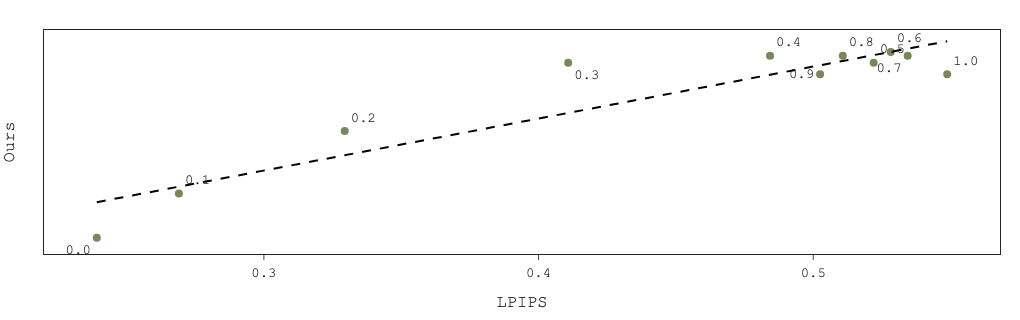

KeyError: 'video-1-segment-5'

In [210]:
from sklearn.linear_model import LinearRegression

models = randomness_levels


for gt_ind, gt in enumerate(gts):
    v_ = int(gt.split('-')[1])
    s_ = int(gt.split('-')[3])

    fig = go.Figure()
    
    fig.update_layout(
        template="simple_white",
        xaxis=dict(title_text="LPIPS", tickmode='linear'),
        yaxis=dict(title_text="Ours",  tickmode='linear'),
        title=dict(
            text="",
            font=dict(size=32, color="black"),
            x=0.5,
            y=0.995
    
        )
    )
    v_s = f'video-{v_}-segment-{s_}'
    X = all_vid_p_sim_score_df[v_s]
    Y = all_vid_temp_score_df[v_s]
    
    fig.add_trace(
        go.Scatter(
            x=X, 
            y=Y,
            text=models,
            mode="markers+text",
            textposition=['bottom left', 'top right', 'top right',
                          'bottom right', 'top right', 'top right',
                          'top right', 'bottom left', 'top right',
                          'middle left', 'top right', 'top right',
                          'top right'],
            marker=dict(color='darkolivegreen'),
            showlegend=False
        )
    )
    model = LinearRegression().fit(np.array(X).reshape(-1,1),Y)
    slope, intercept, r, p, stderr = scipy.stats.linregress(X, Y)
    y_hat = model.predict(np.array(X).reshape(-1,1))
    fig.add_trace(go.Scatter(x=X, y=y_hat, mode='lines',showlegend=False, line_color='Black', line={'dash': 'dash'}))
    
    print(f'{gt} >> r={r}, p-value={p}')
    
    fig.update_traces(
        marker=dict(
            size=8,
            opacity=0.8)
    )
    
    fig.update_layout(legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.0,
            xanchor="right",
            x=0.86,
            bgcolor='rgba(0,0,0,0)',
            title=None,
            font=dict(
                size=19
            )
        ))
        
    fig.update_layout(
        margin=dict(l=20, r=20, t=30, b=20),
        font_family="Courier New",
        title_font_family="Times New Roman",
        font=dict(size=14),
        template='simple_white',
        width=550,
        height=320
    )
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0.0,
            dtick = 0.1,
            mirror=True,
            ticks='outside',
            showline=True,
        ),
        yaxis = dict(
            tickmode = 'linear',
            tick0 = 0.0,
            dtick = 0.1,
            mirror=True,
            ticks='outside',
            showline=True,
        )
    )

    # fig.update_xaxes(range=[0.0, 0.8])
    # fig.update_yaxes(range=[0.0, 0.8])
    
    
    fig.write_image(
        './corr_lpips_ours.pdf', 
        format='pdf'
    )
    
    
    fig.show()